In [17]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from skimage.registration import optical_flow_ilk, optical_flow_tvl1
from scipy.ndimage import gaussian_filter
from scipy.stats import norm
from tqdm.notebook import tqdm
import os
from scipy import stats

In [2]:
DATA_ROOT = "./synthetic_data/"

# 1. Fandom field and Optical Flow generation 
Синтезируем случайное поле (512*512) длительностью 200(?) кадров (пусть будет 25 к/с условно)  с белым шумом 127+/- (какие дисперсии брать, набор какой-то?) 

In [22]:
!pip install OleFileIO_PL

Defaulting to user installation because normal site-packages is not writeable
     -------------------------------------- 120.0/120.0 KB 6.9 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
Discarding https://files.pythonhosted.org/packages/a0/05/f124ecb536ae2090891d3bcb6a65facd1358f4fd10422c1354357687e8dc/OleFileIO_PL-0.42.1.zip#sha256=3466f8e9bce80bbe447aef69cb5653d40d425944cb9f9052bbd8f1511eeca98e (from https://pypi.org/simple/olefileio-pl/): Requested olefile from https://files.pythonhosted.org/packages/a0/05/f124ecb536ae2090891d3bcb6a65facd1358f4fd10422c1354357687e8dc/OleFileIO_PL-0.42.1.zip#sha256=3466f8e9bce80bbe447aef69cb5653d40d425944cb9f9052bbd8f1511eeca98e has inconsistent name: filename has 'olefileio-pl', but metadata has 'olefile'
     -------------------------------------- 118.4/118.4 KB 6.8 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 

You should consider upgrading via the 'C:\Program Files\Python310\python.exe -m pip install --upgrade pip' command.


In [49]:
import os
import sys
module_path = os.path.abspath(os.path.join('./zvi_reader'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [51]:
import zvi_reader


In [3]:
FIELD_SIZE = 512
RECORD_DURATION = 200
RECORD_FPS = 25

FIELD_MEAN = 127
FIELD_STD = 25

SUFFIX = "animation_const"

def frame_generator(field_size, record_duration, field_mean, field_std, sigma=20):
    for i in range(record_duration):
        frame_np = norm.rvs(loc=field_mean, scale=field_std, size=field_size*field_size).reshape((field_size, field_size)).astype(int)
        
        yield frame_np#gaussian_filter(frame_np, sigma=5)

def video_based_frame_generator(video_path, start_frame=0, step=1, blur_sigma=None):
    cap = cv2.VideoCapture(video_path) 
    if not cap.isOpened():
        print("Cannot open camera")
        return
    
    count = start_frame
    cap.set(cv2.CAP_PROP_POS_FRAMES, count)
    while True:
        ret, frame = cap.read()
        if not ret:
            print("Can't receive frame (stream end?). Exiting ...")
            cap.release()
            break            
        grey_np = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        if blur_sigma is not None:
            grey_np = gaussian_filter(grey_np, sigma=blur_sigma)
        count += step 
        cap.set(cv2.CAP_PROP_POS_FRAMES, count)
        yield grey_np
    cap.release()
    
def zvi_based_frame_generator(video_path, start_frame=0, step=1, blur_sigma=None):
    cap = cv2.VideoCapture(video_path) 
    if not cap.isOpened():
        print("Cannot open camera")
        return
    
    count = start_frame
    cap.set(cv2.CAP_PROP_POS_FRAMES, count)
    while True:
        ret, frame = cap.read()
        if not ret:
            print("Can't receive frame (stream end?). Exiting ...")
            cap.release()
            break            
        grey_np = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        if blur_sigma is not None:
            grey_np = gaussian_filter(grey_np, sigma=blur_sigma)
        count += step 
        cap.set(cv2.CAP_PROP_POS_FRAMES, count)
        yield grey_np
    cap.release()

Chech distribution in the frame

In [4]:
frame_np = frame_generator(FIELD_SIZE, RECORD_DURATION, FIELD_MEAN, FIELD_STD).__next__()
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16, 8))

ax1.hist(frame_np.flatten(), bins=64)
ax2.imshow(frame_np)
plt.show()

In [5]:
frame_np = video_based_frame_generator("animation_const_speed.mp4").__next__()
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16, 8))

ax1.hist(frame_np.flatten(), bins=64)
ax2.imshow(frame_np)
plt.show()

Строим и сохраняем оптические потоки

In [6]:
def get_optical_flow_file_name(record_duration, field_size, field_mean, field_std, SUFFIX):
    return f"opt_flow_{record_duration}_{field_size}_{field_mean}_{field_std}_{SUFFIX}.npz"

In [7]:
# --- Compute the optical flow
def compute_optical_low(generator, radius=None, gen_length=None):
    vs, us = [], []
    image0 = None
    for frame_np in tqdm(generator, total=gen_length):
        clear_output(wait=True)
        #Build masked Image
        frame_blur = frame_np#cv2.blur(frame_np,(5,5))
        if image0 is None:
            image0 = frame_blur
        else:
            # --- Compute the optical flow
            image1 = frame_blur
            #v, u = optical_flow_ilk(image0, image1, radius=25)
            v, u = optical_flow_tvl1(image0, image1)
            image0 = image1.copy()
            vs.append(v)
            us.append(u)
    return np.array(vs), np.array(us)

In [8]:
optical_flow_path = os.path.join(DATA_ROOT, 
                                get_optical_flow_file_name(RECORD_DURATION, FIELD_SIZE, FIELD_MEAN, FIELD_STD, SUFFIX ))
if not os.path.exists(optical_flow_path):
    #vs_np, us_np = compute_optical_low(frame_generator(FIELD_SIZE, RECORD_DURATION, FIELD_MEAN, FIELD_STD), SUFFIX, gen_length=RECORD_DURATION)
    vs_np, us_np = compute_optical_low(video_based_frame_generator("animation_const_speed.mp4"), SUFFIX, gen_length=RECORD_DURATION)
    np.savez(optical_flow_path, vs=vs_np, us=us_np)
else:
    with np.load(optical_flow_path) as npzfile:
        vs_np = npzfile["vs"]
        us_np = npzfile["us"]

# 3. Analisys

Оцениваем параметры дисперсии векторов оптического потока среднем(медиана) в окне (при длине окна 1, 2, 4, 8, 16, ...)#

In [8]:
def plot_entire_stat(shape, vs_np, us_np, title="Sequence image sample"):
    v_mean = vs_np.mean(axis=0)# y direction    
    u_mean = us_np.mean(axis=0)# x direction    
    # --- Compute flow magnitude
    norm = np.sqrt(u_mean ** 2 + v_mean ** 2)
    # --- Display
    plt.figure(figsize=(8, 8))
    # --- Quiver plot arguments

    nvec = 25  # Number of vectors to be displayed along each image dimension
    nl, nc = shape
    step = max(nl//nvec, nc//nvec)

    y, x = np.mgrid[:nl:step, :nc:step]
    u_ = u_mean[::step, ::step]
    v_ = v_mean[::step, ::step]

    plt.imshow(norm)
    plt.quiver(x, y, u_, v_, color='r', units='dots',
               angles='xy', scale_units='xy', lw=3)
    plt.title("Optical flow magnitude and vector field")
    plt.axis('off')
    plt.tight_layout()

    plt.show()

margin = 45
#plot_entire_stat((FIELD_SIZE-margin*2,FIELD_SIZE-margin*2), vs_np[:,margin:-margin,margin:-margin], us_np[:,margin:-margin,margin:-margin])
plot_entire_stat((FIELD_SIZE,FIELD_SIZE), vs_np, us_np)

NameError: name 'vs_np' is not defined

In [9]:
from numpy.lib.stride_tricks import sliding_window_view

In [ ]:
import math
# dpcca
base = 1.05
smin = 8
L = 200
smax = L/4
S = []
for degree in range(int(math.log2(smin)/math.log2(base)), int(math.log2(smax)/math.log2(base))):
    new = int(base**degree)
    if not new in S:
        S.append(new)
print(S)

# Integrate with direction

In [27]:
# convert vector to complex numbers
# vs -- real part
# us -- complex part
#vector_field = vs_np[:,margin:-margin,margin:-margin] + 1j * us_np[:,margin:-margin,margin:-margin]
vector_field = vs_np + 1j * us_np

In [28]:
vector_field.shape

(199, 512, 512)

In [29]:
compl_vars_ = []
for w_size in tqdm(S):
    compl_vars_.append(np.std(np.sum(sliding_window_view(vector_field, w_size, axis=0), axis=-1)))

  0%|          | 0/31 [00:00<?, ?it/s]

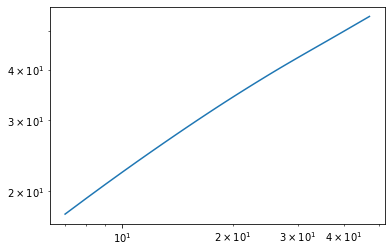

In [30]:
plt.plot(S, compl_vars_)
plt.xscale('log')
plt.yscale('log')

In [33]:

res = stats.linregress(np.log(S), np.log(compl_vars_))

In [34]:
res

LinregressResult(slope=0.5851430389725537, intercept=1.764146654384454, rvalue=0.9988692685245436, pvalue=6.346636937771503e-40, stderr=0.005171616691822455, intercept_stderr=0.01596363315097504)

In [35]:
len(S)

31

In [36]:
cut_point = 15
res = stats.linregress(np.log(S[cut_point:]), np.log(compl_vars_[cut_point:]))
print(res)

LinregressResult(slope=0.5307858600000134, intercept=1.9504408323808402, rvalue=0.9999340723397488, pvalue=1.451228473984574e-28, stderr=0.0016290170551376592, intercept_stderr=0.005662887758093953)


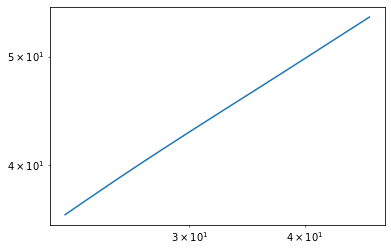

In [37]:
plt.plot(S[cut_point:], compl_vars_[cut_point:])
plt.xscale('log')
plt.yscale('log')

In [24]:
S[cut_point:]

[22, 23, 25, 26, 27, 28, 30, 31, 33, 35, 36, 38, 40, 42, 44, 47]

# Fish Video Analysis

In [16]:
import math
# dpcca
base = 1.15
smin = 8
L = 100#  6000
smax = L/3
S = []
for degree in range(int(math.log2(smin)/math.log2(base)), int(math.log2(smax)/math.log2(base))):
    new = int(base**degree)
    if not new in S:
        S.append(new)
print(S)

[7, 8, 9, 10, 12, 14, 16, 18, 21, 24, 28]


In [11]:
def plot_entire_stat_tresh(shape, vs_np, us_np, title="Sequence image sample", thresh = 0.95):
    v_mean = vs_np.mean(axis=0, where=vs_np>np.quantile(vs_np, thresh))# y direction    
    u_mean = us_np.mean(axis=0, where=us_np>np.quantile(us_np, thresh))# x direction    
    # --- Compute flow magnitude
    norm = np.sqrt(u_mean ** 2 + v_mean ** 2)
    # --- Display
    plt.figure(figsize=(8, 8))
    # --- Quiver plot arguments

    nvec = 25  # Number of vectors to be displayed along each image dimension
    nl, nc = shape
    step = max(nl//nvec, nc//nvec)

    y, x = np.mgrid[:nl:step, :nc:step]
    u_ = u_mean[::step, ::step]
    v_ = v_mean[::step, ::step]

    plt.imshow(norm)
    plt.quiver(x, y, u_, v_, color='r', units='dots',
               angles='xy', scale_units='xy', lw=3)
    plt.title("Optical flow magnitude and vector field")
    plt.axis('off')
    plt.tight_layout()

    plt.show()

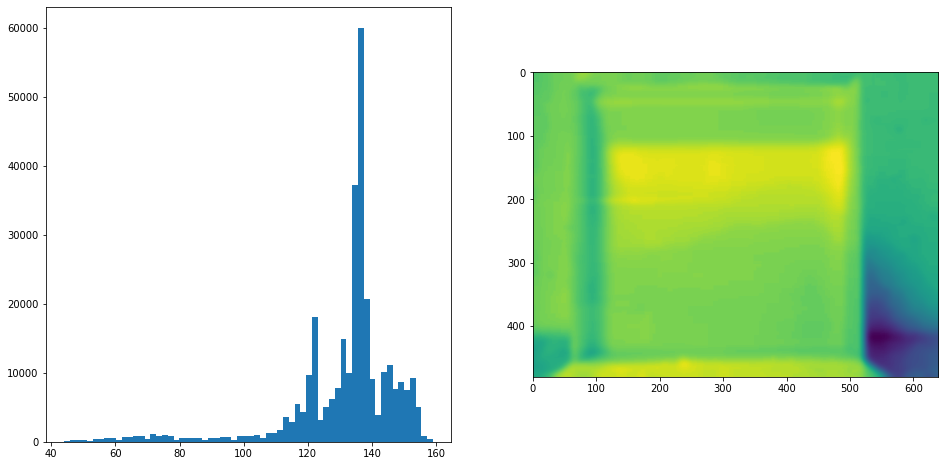

In [85]:
frame_np = video_based_frame_generator("fish_video/9j_1mg_1.avi", blur_sigma=5).__next__()
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16, 8))

ax1.hist(frame_np.flatten(), bins=64)
ax2.imshow(frame_np)
plt.show()

In [54]:
optical_flow_path = os.path.join(DATA_ROOT, 
                                get_optical_flow_file_name(RECORD_DURATION, FIELD_SIZE, FIELD_MEAN, FIELD_STD, SUFFIX ))
if not os.path.exists(optical_flow_path):
    #vs_np, us_np = compute_optical_low(frame_generator(FIELD_SIZE, RECORD_DURATION, FIELD_MEAN, FIELD_STD), SUFFIX, gen_length=RECORD_DURATION)
    vs_np, us_np = compute_optical_low(video_based_frame_generator("animation_const_speed.mp4"), SUFFIX, gen_length=RECORD_DURATION)
    np.savez(optical_flow_path, vs=vs_np, us=us_np)
else:
    with np.load(optical_flow_path) as npzfile:
        vs_np = npzfile["vs"]
        us_np = npzfile["us"]

In [12]:
def get_vid_opt_flow(video_path, cache_path, start_frame=30*15, step=3*30):
    if not os.path.exists(cache_path):
        vs_np, us_np = compute_optical_low(video_based_frame_generator(video_path, start_frame=start_frame, step=step)) # 3 sec for performance
        np.savez(cache_path, vs=vs_np, us=us_np)
    else:
        with np.load(cache_path) as npzfile:
            vs_np = npzfile["vs"]
            us_np = npzfile["us"]
    return vs_np, us_np

In [16]:
from glob import glob

In [88]:
fish_groups = ["caff_100mg",
              "caff_50mg",
              "caff_control",
              "9j_100mg",
              "9j_1mg",
              "9j_control",]

In [89]:
def fish_ds_generator(video_folder, cache_folder, group):
    videos = glob(os.path.join(video_folder, f"{group}_*.avi"))
    for vid in videos:
        vid_name = os.path.split(vid)[1][:-4]
        cache_path = os.path.join(cache_folder, vid_name+".npz")
        yield vid, cache_path
        
for v, c in fish_ds_generator("./fish_video", "./fish_cache_simple", fish_groups[3]):
    print(v, c)

./fish_video\9j_100mg_0.avi ./fish_cache_simple\9j_100mg_0.npz
./fish_video\9j_100mg_1.avi ./fish_cache_simple\9j_100mg_1.npz
./fish_video\9j_100mg_2.avi ./fish_cache_simple\9j_100mg_2.npz
./fish_video\9j_100mg_3.avi ./fish_cache_simple\9j_100mg_3.npz
./fish_video\9j_100mg_4.avi ./fish_cache_simple\9j_100mg_4.npz
./fish_video\9j_100mg_5.avi ./fish_cache_simple\9j_100mg_5.npz
./fish_video\9j_100mg_6.avi ./fish_cache_simple\9j_100mg_6.npz
./fish_video\9j_100mg_7.avi ./fish_cache_simple\9j_100mg_7.npz
./fish_video\9j_100mg_8.avi ./fish_cache_simple\9j_100mg_8.npz
./fish_video\9j_100mg_9.avi ./fish_cache_simple\9j_100mg_9.npz
./fish_video\9j_100mg_10.avi ./fish_cache_simple\9j_100mg_10.npz
./fish_video\9j_100mg_11.avi ./fish_cache_simple\9j_100mg_11.npz
./fish_video\9j_100mg_12.avi ./fish_cache_simple\9j_100mg_12.npz
./fish_video\9j_100mg_13.avi ./fish_cache_simple\9j_100mg_13.npz
./fish_video\9j_100mg_14.avi ./fish_cache_simple\9j_100mg_14.npz
./fish_video\9j_100mg_15.avi ./fish_cache_sim

./fish_video\9j_100mg_0.avi ./fish_cache_simple\9j_100mg_0.npz


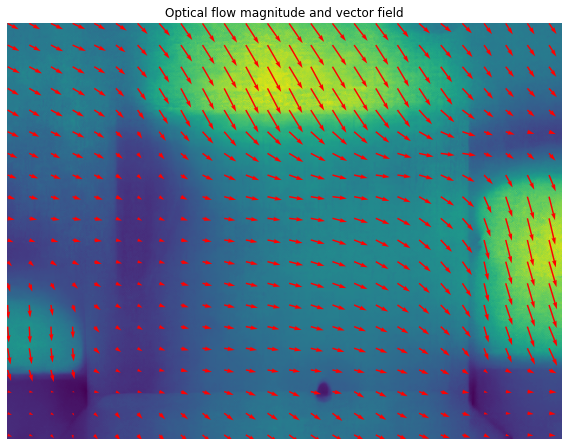

  0%|          | 0/5 [00:00<?, ?it/s]

LinregressResult(slope=0.909217157284208, intercept=-0.2643819322359402, rvalue=0.9997279464169718, pvalue=5.386390171620269e-06, stderr=0.012247229201177833, intercept_stderr=0.029840612774260655)


[]

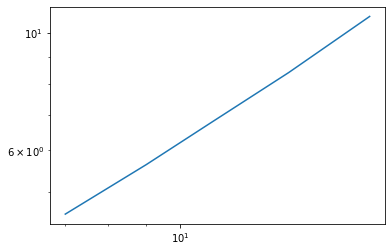

In [121]:
H_fish = []
cut_point = 0
temp = None

for v, c in fish_ds_generator("./fish_video", "./fish_cache_simple", fish_groups[3]):
    print(v, c)
    vs_np, us_np = get_vid_opt_flow(v, c)
    vector_field = vs_np + 1j * us_np
    plot_entire_stat_tresh((vs_np.shape[1],vs_np.shape[2]), vs_np, us_np, thresh=0.5)
    
    vector_field = vs_np + 1j * us_np
    compl_vars_ = []
    for w_size in tqdm(S):
        window = sliding_window_view(vector_field, w_size, axis=0)
        magn = np.abs(window)
        #np.std(np.sum(sliding_window_view(vector_field, w_size, axis=0), axis=-1))
        cond = magn>np.quantile(magn, 0.95)
        H = np.std(np.sum(window, where=cond, axis=-1))
        compl_vars_.append(H)
    H_fish.append(np.array(compl_vars_))
    res = stats.linregress(np.log(S[cut_point:]), np.log(compl_vars_[cut_point:]))
    print(res)
    
    break
    
plt.figure()
plt.plot(S, np.array(H_fish).T)
plt.xscale('log')
plt.yscale('log')
plt.plot()

# Bacterial video

  0%|          | 0/11 [00:00<?, ?it/s]

LinregressResult(slope=0.7685423522801098, intercept=0.3635922116741437, rvalue=0.9993453061088882, pvalue=2.7490311392163922e-14, stderr=0.009274575087071633, intercept_stderr=0.024680249181790917)


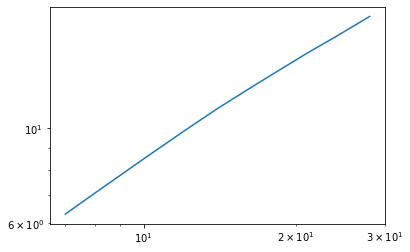

In [19]:
def analyze_bacterial_video(v, c):
    cut_point = 0
    vs_np, us_np = get_vid_opt_flow(v, c, start_frame=0, step=1)
    vector_field = vs_np + 1j * us_np
    plot_entire_stat_tresh((vs_np.shape[1],vs_np.shape[2]), vs_np, us_np, thresh=0.5)
    
    vector_field = vs_np + 1j * us_np
    compl_vars_ = []
    for w_size in tqdm(S):
        #window = sliding_window_view(vector_field, w_size, axis=0)
        #magn = np.abs(window)
        H = np.std(np.sum(sliding_window_view(vector_field, w_size, axis=0), axis=-1))
        #cond = magn>np.quantile(magn, 0.95)
        #H = np.std(np.sum(window, where=cond, axis=-1))
        compl_vars_.append(H)
    res = stats.linregress(np.log(S[cut_point:]), np.log(compl_vars_[cut_point:]))
    print(res)
    
    
    plt.figure()
    plt.plot(S, np.array(compl_vars_))
    plt.xscale('log')
    plt.yscale('log')
    plt.plot()
    
analyze_bacterial_video('./bacterial_video/B.S.380-LA (2.2)(+)_t001.AVI', './bacterial_cache/B.S.380-LA (2.2)(+)_t001.npz')

In [21]:
print(f"S = {S}")

S = [7, 8, 9, 10, 12, 14, 16, 18, 21, 24, 28]
